In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import zipfile
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import pickle
%matplotlib inline

## Pick a problem that interests you and find a dataset; describe the problem and how ML can help

Considering that mental health conditions often develop gradually, early intervention might be a good strategy for treating these conditions. 
This dataset from Kaggle lists different behaviours and quantifies the time spent doing various daily activities.
We could analyse this weekly behavioral and mood data to forecast the combined depression and anxiety scores.
Building a predictive model from the data would enable proactive mental healthcare in the following way:
1. Users could complete a brief weekly survey through a mobile app, reporting sleep patterns, mood ratings, activity levels, and social interactions
2. Data would be sent to a containerized ML service via secure API
3. The model built here would return personalized depression and anxiety risk score, and give this meaning based on its bracket relative to the population.
4. Healthcare providers would receive automated alerts for concerning scores, enabling timely intervention.
5. Users would receive personalized wellness recommendations based on their risk profile

This system could transform reactive mental healthcare into preventive care. The containerized deployment would ensure scalable and reliable service delivery across healthcare networks while maintaining data privacy and security standards required for such medical applications.

In [2]:
# Download data
!kaggle datasets download nagpalprabhavalkar/tech-use-and-stress-wellness

Dataset URL: https://www.kaggle.com/datasets/nagpalprabhavalkar/tech-use-and-stress-wellness
License(s): CC0-1.0
tech-use-and-stress-wellness.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with zipfile.ZipFile('tech-use-and-stress-wellness.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
df = pd.read_csv('Tech_Use_Stress_Wellness.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

## Prepare the data and run EDA

In [5]:
df.head(2).T

,0,1
user_id,1,2
age,53,66
gender,Male,Female
daily_screen_time_hours,6.8,4.1
phone_usage_hours,2.9,2.1
laptop_usage_hours,2.1,1.6
tablet_usage_hours,0.5,0.4
tv_usage_hours,2.0,0.8
social_media_hours,2.3,2.8
work_related_hours,3.0,3.5


In [6]:
df.shape

(5000, 25)

In [7]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')

| Column | Data Type | Description |
|--------|-----------|-------------|
| user_id | int64 | unique key |
| age | int64 | age |
| gender | object | male/female/other |
| daily_screen_time_hours | float64 | hours using screen per day |
| phone_usage_hours | float64 | hours using phone per day |
| laptop_usage_hours | float64 | hours using laptop per day |
| tablet_usage_hours | float64 | hours using tablet per day |
| tv_usage_hours | float64 | hours watching tv per day |
| social_media_hours | float64 | hours on social media per day |
| work_related_hours | float64 | hours on work per day |
| entertainment_hours | float64 | hours on entertainment per day |
| gaming_hours | float64 | hours on gaming per day |
| sleep_duration_hours | float64 | hours of sleep per day |
| sleep_quality | float64 | quality rating of sleep - assume 1 worst and 5 best |
| mood_rating | float64 | mood rating - assume 1 worst and 5 best |
| stress_level | int64 | stress level - assume 1 least stress and 10 highest stress |
| physical_activity_hours_per_week | float64 | hours on physical activity in a week |
| location_type | object | either suburban, urban or other |
| mental_health_score | float64 | mental health score - assume this increases as mental health improves |
| uses_wellness_apps | bool | whether uses a wellness app or not |
| eats_healthy | bool | whether eats healthy or not |
| caffeine_intake_mg_per_day | float64 | amount of caffeine consumed |
| weekly_anxiety_score | float64 | score of anxiety - assume increases as anxiety increases |
| weekly_depression_score | float64 | score of depression - assume increases as depression increases |
| mindfulness_minutes_per_day | float64 | times spent on any mindful activity - eg meditation, wellness app |

In [8]:
df.describe()

,user_id,age,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,...,sleep_duration_hours,sleep_quality,mood_rating,stress_level,physical_activity_hours_per_week,mental_health_score,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,44.70120,5.037860,1.994400,1.555160,0.663060,1.433040,3.276920,3.360240,1.662200,...,7.370080,4.009400,4.447900,5.718400,2.65934,64.766200,142.321260,8.631800,7.520000,18.550820
std,1443.520003,17.26688,1.835637,0.890671,1.025994,0.525438,0.928931,1.203655,0.827026,0.659647,...,0.543875,0.663777,2.768151,2.915064,2.28885,13.095779,50.468392,5.092565,4.672383,7.992543
min,1.000000,15.00000,1.000000,0.200000,0.000000,0.000000,0.000000,0.300000,0.700000,0.000000,...,5.400000,1.000000,1.000000,1.000000,0.00000,31.000000,0.000000,0.000000,0.000000,5.000000
25%,1250.750000,30.00000,3.700000,1.400000,0.700000,0.200000,0.700000,2.400000,3.100000,1.200000,...,7.000000,4.000000,1.700000,3.000000,0.60000,54.000000,108.475000,5.000000,4.000000,12.400000
50%,2500.500000,45.00000,5.000000,2.000000,1.500000,0.600000,1.400000,3.600000,3.700000,1.600000,...,7.400000,4.000000,4.300000,6.000000,2.30000,65.000000,141.650000,8.000000,7.000000,17.200000
75%,3750.250000,60.00000,6.300000,2.600000,2.300000,1.000000,2.100000,4.500000,3.900000,2.100000,...,7.700000,4.000000,6.700000,8.000000,4.20000,75.000000,176.400000,12.000000,11.000000,23.800000
max,5000.000000,74.00000,10.000000,5.000000,5.000000,2.900000,4.000000,4.500000,4.500000,3.900000,...,9.000000,5.000000,10.000000,10.000000,11.80000,100.000000,341.200000,21.000000,21.000000,42.000000


In [9]:
# Check for null values
df.isnull().sum()

user_id                             0
age                                 0
gender                              0
daily_screen_time_hours             0
phone_usage_hours                   0
laptop_usage_hours                  0
tablet_usage_hours                  0
tv_usage_hours                      0
social_media_hours                  0
work_related_hours                  0
entertainment_hours                 0
gaming_hours                        0
sleep_duration_hours                0
sleep_quality                       0
mood_rating                         0
stress_level                        0
physical_activity_hours_per_week    0
location_type                       0
mental_health_score                 0
uses_wellness_apps                  0
eats_healthy                        0
caffeine_intake_mg_per_day          0
weekly_anxiety_score                0
weekly_depression_score             0
mindfulness_minutes_per_day         0
dtype: int64

<Axes: xlabel='weekly_depression_anxiety_score', ylabel='Count'>

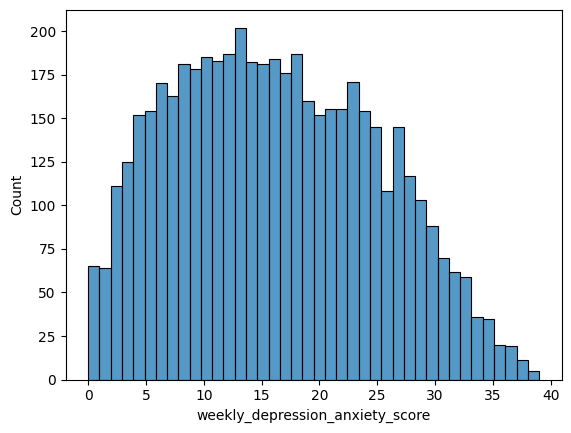

In [10]:
# Assume y is the sum of weekly_anxiety_score and weekly_depression_score
df['weekly_depression_anxiety_score'] = df.weekly_anxiety_score + df.weekly_depression_score

# Looking at distribution of y-value -> no log transformation needed
sns.histplot(df.weekly_depression_anxiety_score, bins=40)

In [11]:
# Create 5 bins of the weekly_depression_anxiety_score to show relative position - high and very high mean that the person's
# depression and anxiety is increasing.
df['weekly_depression_anxiety_score_bin'] = pd.cut(df['weekly_depression_anxiety_score'], 5, 
                                                   labels=["very low", "low", "medium", "high", "very high"])

<Axes: xlabel='weekly_depression_anxiety_score_bin', ylabel='count'>

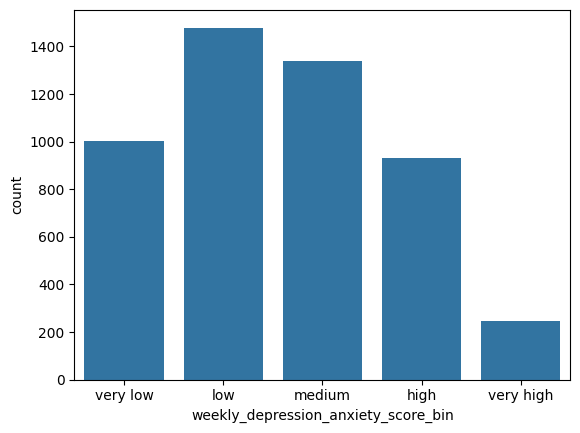

In [12]:
# Simple count plot of bins
sns.countplot(data=df, x='weekly_depression_anxiety_score_bin')

In [13]:
# Create mapping dictionary for model lookups -> maps this to levels eg 16 : 'medium'
mapping_dict = dict(zip(df['weekly_depression_anxiety_score'], df['weekly_depression_anxiety_score_bin']))
mapping_dict = dict(sorted(mapping_dict.items()))

# Save to pickle file to use with model
with open('mapping_dict.pkl', 'wb') as f_out:
    pickle.dump(mapping_dict, f_out)
    print('mapping_dict saved successfully to file')

mapping_dict saved successfully to file


### Validation framework

In [14]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train['weekly_depression_anxiety_score']
y_val = df_val['weekly_depression_anxiety_score']

del df_train['weekly_anxiety_score']
del df_train['weekly_depression_score']
del df_train['weekly_depression_anxiety_score'] # Deleting all 3 columns to ensure no leakage

del df_val['weekly_anxiety_score']
del df_val['weekly_depression_score']
del df_val['weekly_depression_anxiety_score'] # Deleting all 3 columns to ensure no leakage

In [15]:
df_train_full.head()

,user_id,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,...,location_type,mental_health_score,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day,weekly_depression_anxiety_score,weekly_depression_anxiety_score_bin
1233,1234,44,female,1.6,0.2,1.0,0.1,1.4,3.3,3.2,...,urban,68.0,False,True,24.6,8.0,9.0,26.7,17.0,medium
1056,1057,65,male,2.7,0.9,1.7,0.6,0.5,1.0,1.4,...,urban,73.0,False,False,159.9,1.0,0.0,26.8,1.0,very low
1686,1687,17,female,3.6,2.0,0.1,0.7,0.0,4.0,3.6,...,urban,59.0,False,True,166.8,10.0,8.0,19.8,18.0,medium
187,188,46,male,7.4,3.3,1.2,1.2,2.8,4.5,3.8,...,suburban,62.0,False,False,67.7,8.0,13.0,11.8,21.0,medium
3840,3841,20,female,5.2,2.6,0.4,1.2,0.1,4.5,3.7,...,suburban,58.0,False,False,51.9,18.0,9.0,12.0,27.0,high


### Mutual Information

In [16]:
# Need to handle one-hot encoding of categorical features before applying the MI score

dv = DictVectorizer(sparse=False)

mi_cols = [i for i in df_train_full.columns if i not in ['user_id', 'weekly_anxiety_score', 'weekly_depression_score', 'weekly_depression_anxiety_score']]
train_dict = df_train_full[mi_cols].to_dict(orient='records')
dv.fit(train_dict)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [17]:
X_train_full = dv.transform(train_dict)

In [18]:
def calculate_mi(x):
    return mutual_info_regression(x, df_train_full.weekly_depression_anxiety_score)

In [19]:
mi_results = {name : float(result) for name, result in zip(dv.feature_names_, calculate_mi(X_train_full))}

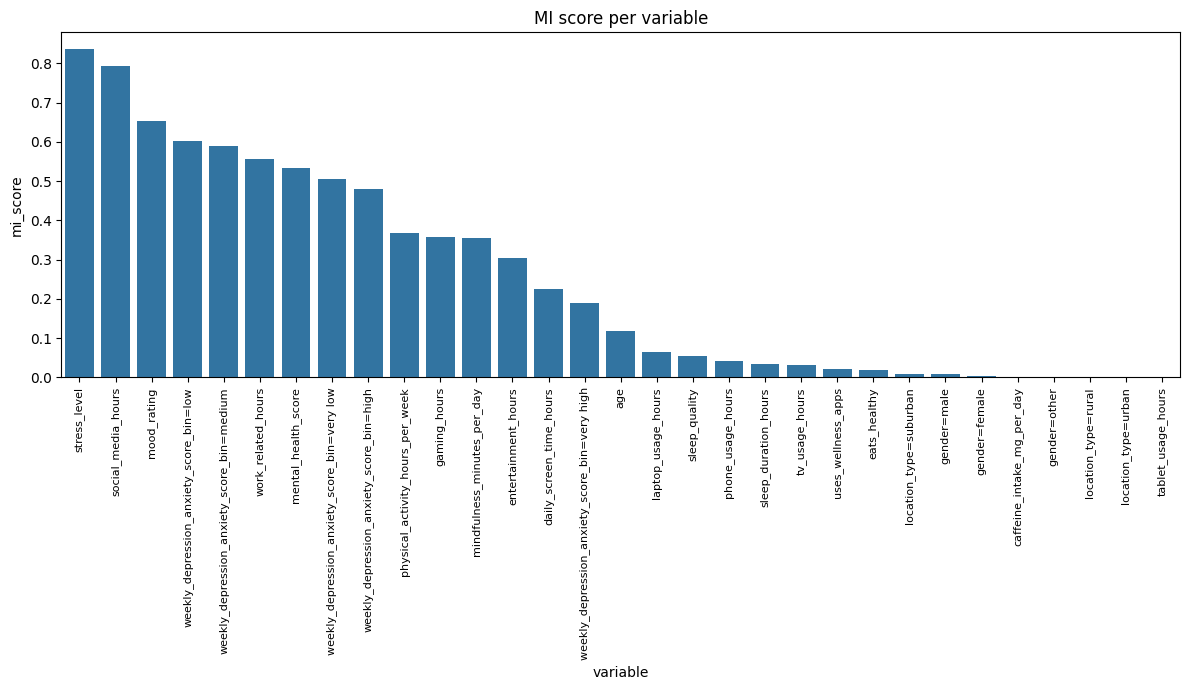

In [20]:
# Sort output descending to see most important variables
mi_results = dict(sorted(mi_results.items(), key=lambda item: item[1], reverse=True))
mi_results_df = pd.DataFrame.from_dict(mi_results, orient='index').reset_index()
mi_results_df.columns = ['variable', 'mi_score']

plt.figure(figsize=(12, 7))
sns.barplot(data=mi_results_df, x="variable", y="mi_score")
plt.xticks(rotation=90, fontsize=8)  # Rotate labels
plt.title('MI score per variable')
plt.tight_layout()

In [21]:
def faceted_scatterplot(df, target_variable='weekly_depression_anxiety_score', feature_columns=None, col_wrap=3, height=3, aspect=1.2):
    """
    Create faceted scatterplots for multiple features vs target variable.
    
    Parameters:
    -----------
    df : DataFrame
        Your dataset
    target_variable : str
        Name of the predicted variable (y-axis)
    feature_columns : list, optional
        List of feature names to plot. If None, plots all numeric columns except target
    col_wrap : int
        Number of plots per row
    height : float
        Height of each facet in inches
    aspect : float
        Aspect ratio of each facet (width = height * aspect)
    """
    
    # Reshape data to long format for faceting
    df_long = df.melt(
        id_vars=[target_variable],
        value_vars=feature_columns,
        var_name='feature',
        value_name='value'
    )
    
    # Create faceted plot
    g = sns.FacetGrid(df_long, col='feature', col_wrap=col_wrap, height=height, aspect=aspect, sharex=False, sharey=True)
    
    # Add scatter plots
    g.map(plt.scatter, 'value', target_variable, alpha=0.5, s=20)
    
    # Add regression lines
    g.map(sns.regplot, 'value', target_variable, scatter=False, color='red', line_kws={'linewidth': 1.5})
    
    # Customize
    g.set_axis_labels('', target_variable)
    g.set_titles(col_template='{col_name}')
    
    # Add correlations to each facet
    for ax, feature in zip(g.axes.flat, feature_columns):
        corr = df[feature].corr(df[target_variable])
        ax.text(0.05, 0.95, f'r = {corr:.2f}', 
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7, pad=0.3),
                fontsize=9)
    
    plt.tight_layout()
    plt.show()

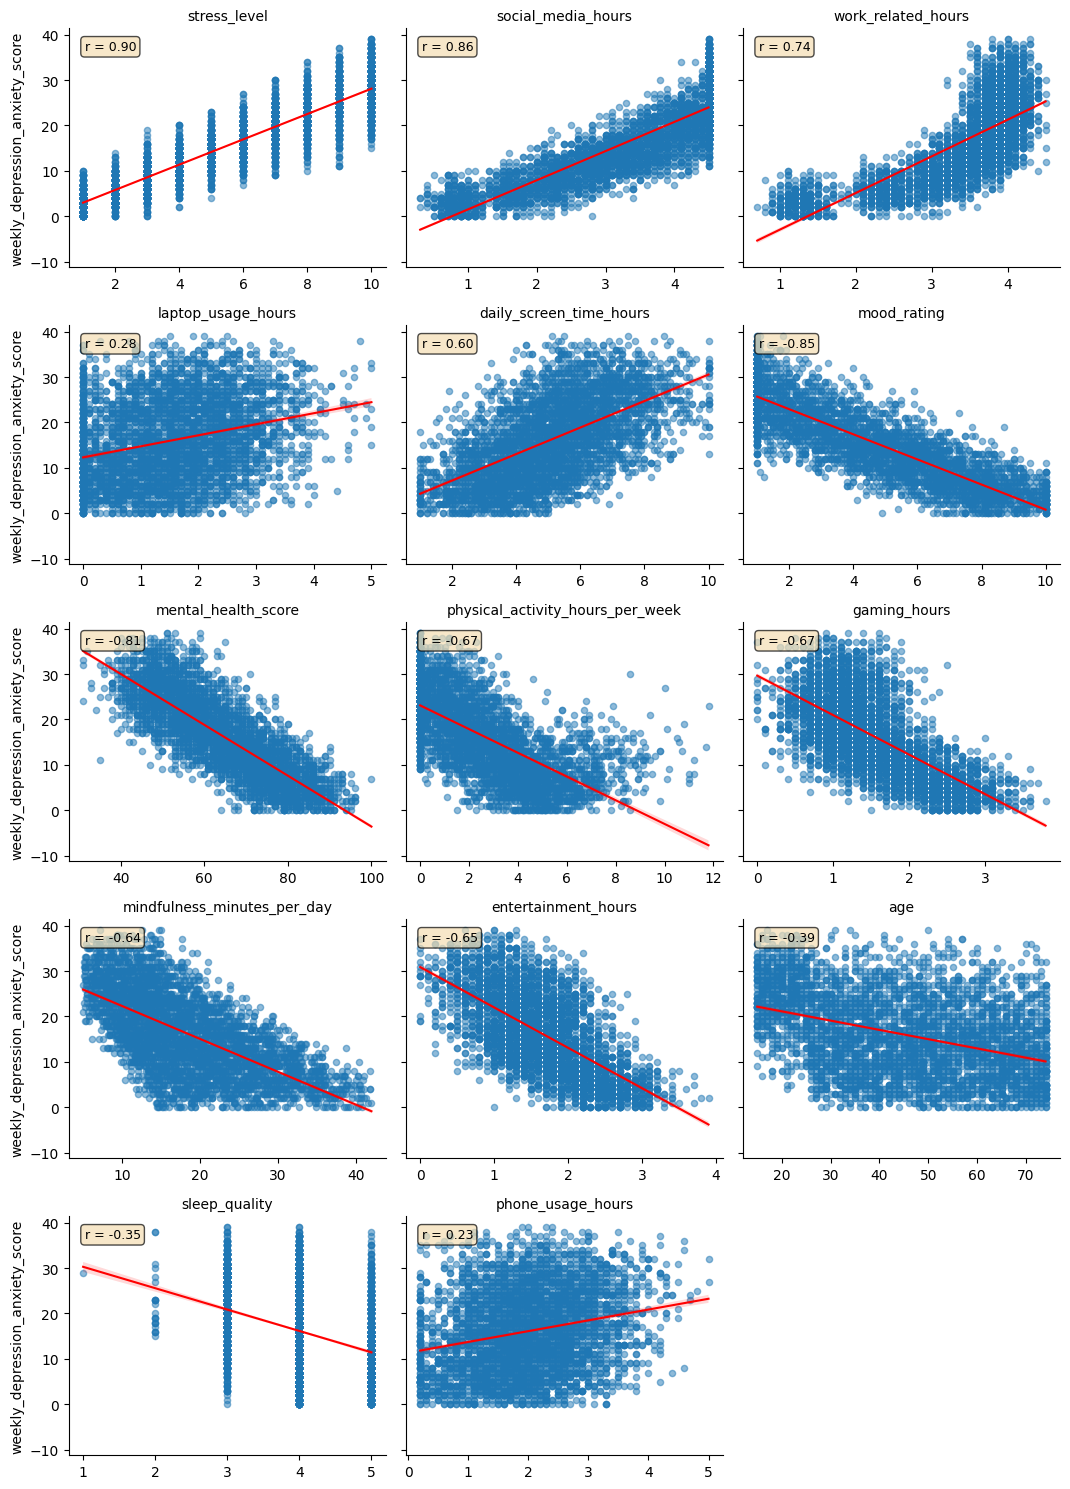

In [22]:
faceted_scatterplot(df=df_train_full, target_variable= 'weekly_depression_anxiety_score', 
                    feature_columns=['stress_level', 'social_media_hours',  'work_related_hours', 'laptop_usage_hours', 'daily_screen_time_hours', 'mood_rating', 'mental_health_score', 
                                    'physical_activity_hours_per_week', 'gaming_hours', 'mindfulness_minutes_per_day', 'entertainment_hours', 
                                     'age', 'sleep_quality', 'phone_usage_hours'])

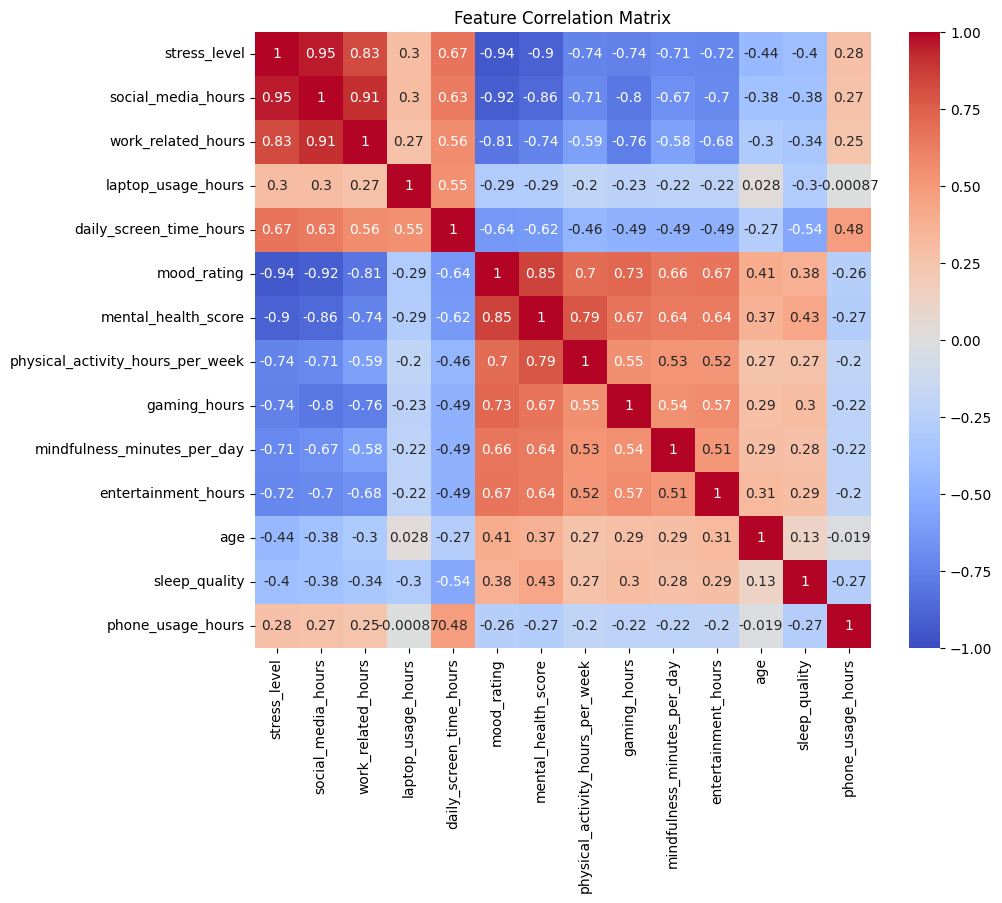

In [23]:
# Above shows that these variables have strong linear relationships with the predicted variable.
# Need to check for multicollinearity or model coefficients will be unstable and unreliable

# Check correlation matrix
correlation_matrix = df_train_full[['stress_level', 'social_media_hours',  'work_related_hours', 'laptop_usage_hours', 'daily_screen_time_hours', 'mood_rating', 'mental_health_score', 
                                    'physical_activity_hours_per_week', 'gaming_hours', 'mindfulness_minutes_per_day', 'entertainment_hours', 
                                     'age', 'sleep_quality', 'phone_usage_hours']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [24]:
# Drop social_media_hours and 'work_related_hours' because they are highly correlated with 'stress_level' and will afect model performance.
# We can assume that this information is already encoded in 'stress_level' due to the high correlation.

# Also drop two of 'mental_health_score', 'stress_level' and 'mood_rating' (giving same information)

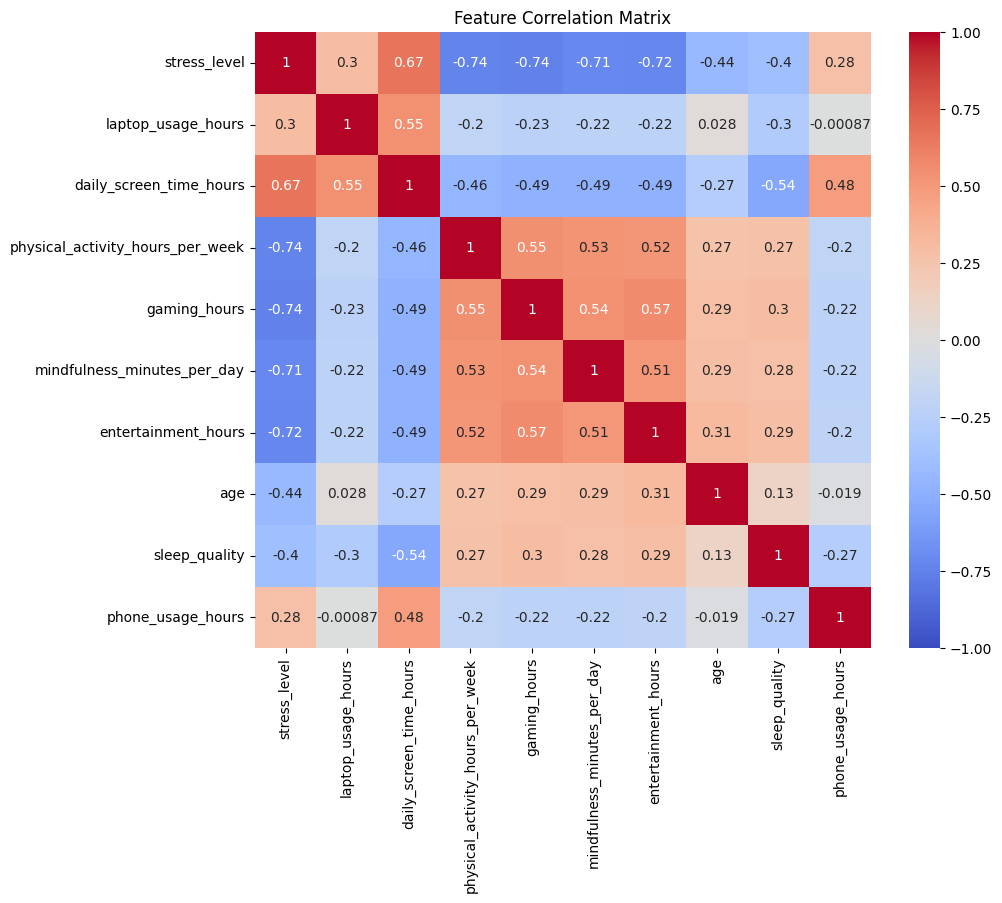

In [25]:
# Plot remaining variables again to check correlation

correlation_matrix = df_train_full[['stress_level', 'laptop_usage_hours', 'daily_screen_time_hours',  
                                    'physical_activity_hours_per_week', 'gaming_hours', 'mindfulness_minutes_per_day', 'entertainment_hours', 
                                     'age', 'sleep_quality', 'phone_usage_hours']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True)
plt.title('Feature Correlation Matrix')
plt.show()

## Training the model: Linear regression

In [26]:
x_columns = ['stress_level', 'laptop_usage_hours', 'daily_screen_time_hours', 'physical_activity_hours_per_week', 
                    'gaming_hours', 'mindfulness_minutes_per_day', 'entertainment_hours', 'age', 'sleep_quality', 'phone_usage_hours']

X_train = df_train[x_columns]
X_val = df_val[x_columns]

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [27]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_val)

In [28]:
# Evaluate via RMSE

def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return float(np.sqrt(mse))

In [29]:
lr_metric = rmse(y_val, y_pred)

print(f"RMSE for Linear Regression: {lr_metric:.4f}")

RMSE for Linear Regression: 3.8103


## Decision Tree

In [30]:
clf = tree.DecisionTreeRegressor().fit(X_train, y_train)
y_pred = clf.predict(X_val)

dt_metric = rmse(y_val, y_pred)

print(f"RMSE for Decision Trees: {dt_metric:.4f}")

RMSE for Decision Trees: 5.7420


## Random Forests

In [31]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, max_depth=20).fit(X_train, y_train)
y_pred = rf.predict(X_val)

rf_metric = rmse(y_val, y_pred)

print(f"RMSE for Random Forests: {rf_metric:.4f}")

RMSE for Random Forests: 4.1267


In [32]:
# Sidebar: check feature importances correspond to what MI tells us
feature_importances = dict( zip(x_columns, rf.feature_importances_) )
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

for key, value in feature_importances.items():
    value = float(value)
    print(f"{key}: {value:.4f}")

stress_level: 0.8137
mindfulness_minutes_per_day: 0.0272
daily_screen_time_hours: 0.0253
age: 0.0241
phone_usage_hours: 0.0240
laptop_usage_hours: 0.0206
gaming_hours: 0.0203
entertainment_hours: 0.0195
physical_activity_hours_per_week: 0.0188
sleep_quality: 0.0065


In [33]:
### Tuning parameters within Random Forests

In [34]:
number_estimators = list(range(10, 201, 10))
depth = [5, 10, 20]

rmse_results = {}
for d in depth:
    rmses = []
    for estimator in number_estimators:
        rf = RandomForestRegressor(n_estimators=estimator, random_state=1, max_depth=d).fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rf_metric = rmse(y_val, y_pred)
        rmses.append(rf_metric)
    rmse_results[d] = rmses

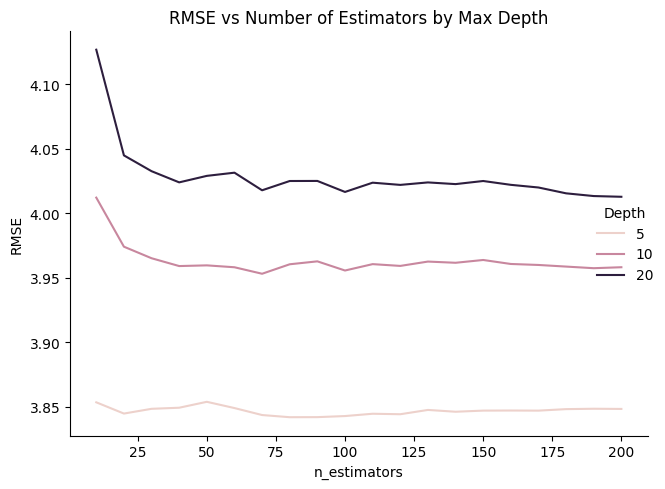

In [35]:
# Convert nested dictionary to a DataFrame
plot_data = []
for depth_key, rmse_values in rmse_results.items():
    for param, rmse_val in zip(number_estimators, rmse_values):
        plot_data.append({
            'n_estimators': param,
            'RMSE': rmse_val,
            'Depth': depth_key  
        })

df_plot = pd.DataFrame(plot_data)

# Create the line plot
sns.relplot(data=df_plot, x='n_estimators', y='RMSE', hue='Depth', kind='line', markers=True, aspect=1.2)

plt.title('RMSE vs Number of Estimators by Max Depth')
plt.tight_layout()

In [36]:
# Since depth=5 gives the lowest RMSE will further sort to get best n_estimators parameter
depth_5 = dict(zip(list(range(10, 201, 10)), rmse_results[5]))
depth_5_sorted = dict(sorted(depth_5.items(), key=lambda item: item[1], reverse=True))

print(f"Lowest RMSE for Random Forests at depth = 5 and n_estimators = {next(iter(depth_5_sorted))}: {next(iter(depth_5_sorted.values())) :.4f}")

Lowest RMSE for Random Forests at depth = 5 and n_estimators = 50: 3.8540


## XG Boost

In [37]:
xgb_params = {
    'learning_rate': 0.3, #eta
    'max_depth': 5, #
    'min_child_weight': 1, #
    'objective': 'reg:squarederror',
    'n_jobs': 8,
    'random_state': 1,
    'verbosity': 1,
    'n_estimators': 50
}

xgb_model = XGBRegressor(**xgb_params).fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)

xgb_metric = rmse(y_val, y_pred)

print(f"RMSE for XG Boost: {rf_metric:.4f}")

RMSE for XG Boost: 4.0128


In [38]:
# Optimise hyperparameter combinations via grid search

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],  # eta 
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [20, 50, 100, 200, 500, 1000]  # num trees
}

# Create the base model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=8,  # nthread in sklearn
    random_state=1,  # seed in sklearn
    verbosity=1
)

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross validation
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1,  # use all cores
    verbose=1
)

# Fit the grid search (this replaces xgb.train)
grid_search.fit(X_train, y_train)

# Get results
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

val_predictions = best_model.predict(X_val)
val_score = rmse(y_val, val_predictions)
print(f"RMSE for best parameters: {val_score:.4f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 20}
RMSE for best parameters: 3.8653


In [39]:
df_train_full.shape

(4000, 27)

In [40]:
# Since RMSE for Random Forests shows a lower value, optimise this further by performing hyperparameter gridsearch.
# Random Forests might perform better than XG Boost due to the standardization applied, since data source is not well
# known it can be assumed that the data is not real-world.

In [41]:
# Optimise hyperparameter combinations via grid search

param_grid = { 
    'max_depth': [1, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 5, 8],
    'n_estimators': list(range(10, 201, 10))  # num trees
}

# Create the base model
rf = RandomForestRegressor(
    criterion='squared_error',
    random_state=1,  # seed in sklearn
    verbose=1
)

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross validation
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1,  # use all cores
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get results
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

val_predictions = best_model.predict(X_val)
val_score = rmse(y_val, val_predictions)
print(f"RMSE for best parameters: {val_score:.4f}")

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE for best parameters: 3.8254


In [42]:
# Convert .ipynb to straight py file and rename it to _train.py
! jupyter nbconvert --to=script notebook.ipynb
! mv notebook.py _train.py

[NbConvertApp] Converting notebook notebook.ipynb to script
[NbConvertApp] Writing 17802 bytes to notebook.py
